In [41]:
from ase.build import molecule
from mace.calculators import mace_mp

In [85]:
ethane_stagggered = molecule('C2H6')
ethane_eclipsed = ethane_stagggered.copy()
ethane_eclipsed.rotate_dihedral(0, 2, 1, 5, angle=60, indices=[5, 6, 7])

In [86]:
view(ethane_stagggered, viewer='x3d')

In [87]:
view(ethane_eclipsed, viewer='x3d')

In [102]:
from ase.optimize import FIRE, BFGS

calc = mace_mp(default_dtype='float64', device='cuda')

Using Materials Project MACE for MACECalculator with /home/cyrus/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [89]:
from ase import units

In [90]:
ethane_stagggered.calc = calc

opt = BFGS(ethane_stagggered)

opt.run()
print(f'staggered energy: {ethane_stagggered.get_potential_energy() * units.eV / (units.kcal / units.mol)}')

      Step     Time          Energy          fmax
BFGS:    0 17:10:02      -40.611619        0.042774
staggered energy: -936.5262010850399


In [91]:
ethane_eclipsed.calc = calc

opt = BFGS(ethane_eclipsed)
opt.run()
print(f'eclipsed energy: {ethane_eclipsed.get_potential_energy() * units.eV / (units.kcal / units.mol)}')

      Step     Time          Energy          fmax
BFGS:    0 17:10:09      -40.042533        1.912078
BFGS:    1 17:10:09      -40.136185        1.836917
BFGS:    2 17:10:09      -40.378045        1.476458
BFGS:    3 17:10:09      -40.508459        1.509217
BFGS:    4 17:10:09      -40.549672        0.692085
BFGS:    5 17:10:09      -40.561600        0.433105
BFGS:    6 17:10:10      -40.574291        0.553921
BFGS:    7 17:10:10      -40.589639        0.501967
BFGS:    8 17:10:10      -40.597706        0.309820
BFGS:    9 17:10:10      -40.600004        0.120557
BFGS:   10 17:10:10      -40.600732        0.107069
BFGS:   11 17:10:11      -40.601776        0.142338
BFGS:   12 17:10:11      -40.602725        0.138597
BFGS:   13 17:10:11      -40.603142        0.062846
BFGS:   14 17:10:11      -40.603219        0.015885
eclipsed energy: -936.33248081803


In [92]:
view(ethane_eclipsed, viewer='x3d')

In [93]:
from ase.geometry.analysis import Analysis



In [152]:
ana = Analysis(ethane_stagggered)

CCBonds = ana.get_bonds('C', 'C', unique=True)
CHBonds = ana.get_bonds('C', 'H', unique=True)

HCHAngles = ana.get_angles('H', 'C', 'H', unique=True)
HCCAngles = ana.get_angles('H', 'C', 'C', unique=True)

CCBondValues = np.array(ana.get_values(CCBonds))
CHBondValues = np.array(ana.get_values(CHBonds))
print(CCBondValues.mean())
print(CHBondValues.mean())

HCHAnglesValues = np.array(ana.get_values(HCHAngles))
HCCAnglesValues = np.array(ana.get_values(HCCAngles))

print(HCHAnglesValues.mean())
print(HCCAnglesValues.mean())

1.524418
1.092847163518123
107.69924660701571
111.18985659973538


In [153]:
ana = Analysis(ethane_eclipsed)

CCBonds = ana.get_bonds('C', 'C', unique=True)
CHBonds = ana.get_bonds('C', 'H', unique=True)

HCHAngles = ana.get_angles('H', 'C', 'H', unique=True)
HCCAngles = ana.get_angles('H', 'C', 'C', unique=True)

CHBondValues = np.array(ana.get_values(CHBonds))
print(CCBondValues.mean())
print(CHBondValues.mean())
HCHAnglesValues = np.array(ana.get_values(HCHAngles))
HCCAnglesValues = np.array(ana.get_values(HCCAngles))

print(HCHAnglesValues.mean())
print(HCCAnglesValues.mean())

1.524418
1.091645901947406
107.67427366349791
111.21331184070289


In [137]:
from ase.constraints import FixInternals

ana = Analysis(ethane_stagggered)
dihedral_indices = ana.get_dihedrals('H', 'C', 'C', 'H')
dihedral_values = ana.get_values(dihedral_indices)

dihedral_indices = [0, 2, 1, 5]

# c = FixInternals(dihedrals_deg=list(zip(*dihedral_values, *dihedral_indices)))

c = FixInternals(dihedrals_deg=[[ethane_stagggered.get_dihedral(*dihedral_indices), dihedral_indices]])

In [98]:
from tqdm.auto import tqdm

/home/cyrus/miniconda3/envs/dev-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:

# Rigid scan

dihedrals = np.arange(0, 360, 10)
energies = []

for diheral in tqdm(dihedrals):
    clone = ethane_stagggered.copy()
    clone.rotate_dihedral(0, 2, 1, 5, angle=diheral, indices=[5, 6, 7])

    clone.calc = calc
    energies.append(clone.get_potential_energy())

rigid_energies = np.array(energies)

100%|█████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.31it/s]


In [139]:

# Relaxed scan

dihedral_indices = [0, 2, 1, 5]
dihedrals = np.arange(0, 360, 10)
energies = []

for diheral in tqdm(dihedrals):
    clone = ethane_stagggered.copy()
    clone.rotate_dihedral(0, 2, 1, 5, angle=diheral, indices=[5, 6, 7])

    c = FixInternals(dihedrals_deg=[[clone.get_dihedral(*dihedral_indices), dihedral_indices]])
    clone.set_constraint(c)
    
    clone.calc = calc
    opt = BFGS(clone)
    opt.run()
    energies.append(clone.get_potential_energy())

relaxed_energies = np.array(energies)

  0%|                                                              | 0/36 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 17:58:15      -40.611619        0.042774


  3%|█▌                                                    | 1/36 [00:00<00:26,  1.33it/s]

      Step     Time          Energy          fmax
BFGS:    0 17:58:15      -40.596544        0.286723
BFGS:    1 17:58:15      -40.599145        0.217958
BFGS:    2 17:58:16      -40.603382        0.214369
BFGS:    3 17:58:16      -40.607125        0.183538
BFGS:    4 17:58:16      -40.608385        0.101421
BFGS:    5 17:58:16      -40.609019        0.090334
BFGS:    6 17:58:16      -40.609562        0.092864
BFGS:    7 17:58:16      -40.610057        0.097846
BFGS:    8 17:58:16      -40.610460        0.068941
BFGS:    9 17:58:17      -40.610764        0.053189
BFGS:   10 17:58:17      -40.610966        0.047718


  6%|███                                                   | 2/36 [00:02<00:43,  1.28s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:17      -40.550314        0.557056
BFGS:    1 17:58:17      -40.560420        0.475882
BFGS:    2 17:58:17      -40.578215        0.450018
BFGS:    3 17:58:18      -40.594056        0.412086
BFGS:    4 17:58:18      -40.598708        0.221339
BFGS:    5 17:58:18      -40.600649        0.162706
BFGS:    6 17:58:18      -40.602709        0.188175
BFGS:    7 17:58:18      -40.605099        0.201234
BFGS:    8 17:58:18      -40.606766        0.133127
BFGS:    9 17:58:18      -40.607616        0.083004
BFGS:   10 17:58:19      -40.608141        0.086031
BFGS:   11 17:58:19      -40.608762        0.093311
BFGS:   12 17:58:19      -40.609477        0.100042
BFGS:   13 17:58:19      -40.610080        0.071645
BFGS:   14 17:58:19      -40.610419        0.044962


  8%|████▌                                                 | 3/36 [00:05<01:02,  1.90s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:20      -40.472712        0.797844
BFGS:    1 17:58:20      -40.495212        0.765545
BFGS:    2 17:58:20      -40.537963        0.704122
BFGS:    3 17:58:20      -40.575056        0.639485
BFGS:    4 17:58:20      -40.584790        0.344527
BFGS:    5 17:58:20      -40.588863        0.225261
BFGS:    6 17:58:21      -40.592857        0.281779
BFGS:    7 17:58:21      -40.598052        0.276170
BFGS:    8 17:58:21      -40.601532        0.188561
BFGS:    9 17:58:21      -40.603085        0.104759
BFGS:   10 17:58:21      -40.603985        0.112210
BFGS:   11 17:58:22      -40.605253        0.159726
BFGS:   12 17:58:22      -40.606836        0.186161
BFGS:   13 17:58:22      -40.608016        0.111532
BFGS:   14 17:58:22      -40.608501        0.061112
BFGS:   15 17:58:22      -40.608729        0.059896
BFGS:   16 17:58:22      -40.608940        0.065730
BFGS:   17 17:58:22      -40.609161        0.056247
BFGS:   18 17:

 11%|██████                                                | 4/36 [00:08<01:17,  2.42s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:23      -40.362096        1.122906
BFGS:    1 17:58:23      -40.403439        1.105724
BFGS:    2 17:58:23      -40.487902        0.905291
BFGS:    3 17:58:23      -40.552131        0.791800
BFGS:    4 17:58:23      -40.569237        0.429868
BFGS:    5 17:58:24      -40.575308        0.265395
BFGS:    6 17:58:24      -40.582544        0.368171
BFGS:    7 17:58:24      -40.590099        0.339695
BFGS:    8 17:58:24      -40.595712        0.241575
BFGS:    9 17:58:24      -40.597891        0.119094
BFGS:   10 17:58:24      -40.599200        0.127875
BFGS:   11 17:58:24      -40.601081        0.199868
BFGS:   12 17:58:25      -40.603434        0.247526
BFGS:   13 17:58:25      -40.605101        0.161646
BFGS:   14 17:58:25      -40.605796        0.087278
BFGS:   15 17:58:25      -40.606168        0.088851
BFGS:   16 17:58:25      -40.606585        0.089348
BFGS:   17 17:58:25      -40.607026        0.097578
BFGS:   18 17:

 14%|███████▌                                              | 5/36 [00:11<01:21,  2.64s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:26      -40.217467        1.500216
BFGS:    1 17:58:26      -40.282083        1.479445
BFGS:    2 17:58:26      -40.435265        1.107543
BFGS:    3 17:58:26      -40.527125        0.994270
BFGS:    4 17:58:27      -40.555207        0.516697
BFGS:    5 17:58:27      -40.563533        0.309911
BFGS:    6 17:58:27      -40.572621        0.434111
BFGS:    7 17:58:27      -40.582424        0.429692
BFGS:    8 17:58:27      -40.590063        0.277684
BFGS:    9 17:58:27      -40.592969        0.127344
BFGS:   10 17:58:27      -40.594589        0.149788
BFGS:   11 17:58:28      -40.596792        0.199188
BFGS:   12 17:58:28      -40.599618        0.256187
BFGS:   13 17:58:28      -40.601775        0.178647
BFGS:   14 17:58:28      -40.602799        0.107609
BFGS:   15 17:58:28      -40.603344        0.107100
BFGS:   16 17:58:28      -40.603915        0.090851
BFGS:   17 17:58:29      -40.604517        0.100037
BFGS:   18 17:

 17%|█████████                                             | 6/36 [00:14<01:25,  2.84s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:29      -40.042533        1.912078
BFGS:    1 17:58:29      -40.136239        1.850848
BFGS:    2 17:58:29      -40.383437        1.260303
BFGS:    3 17:58:30      -40.507984        1.158839
BFGS:    4 17:58:30      -40.544749        0.604599
BFGS:    5 17:58:30      -40.556215        0.347036
BFGS:    6 17:58:30      -40.564991        0.448892
BFGS:    7 17:58:30      -40.577102        0.490551
BFGS:    8 17:58:30      -40.585793        0.297844
BFGS:    9 17:58:31      -40.589310        0.134350
BFGS:   10 17:58:31      -40.591113        0.164214
BFGS:   11 17:58:31      -40.593422        0.207556
BFGS:   12 17:58:31      -40.596402        0.258968
BFGS:   13 17:58:31      -40.598896        0.195994
BFGS:   14 17:58:31      -40.600246        0.118704
BFGS:   15 17:58:32      -40.600929        0.115975
BFGS:   16 17:58:32      -40.601572        0.096006
BFGS:   17 17:58:32      -40.602273        0.110337
BFGS:   18 17:

 19%|██████████▌                                           | 7/36 [00:18<01:29,  3.08s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:33      -39.848546        2.219592
BFGS:    1 17:58:33      -39.969049        2.144747
BFGS:    2 17:58:33      -40.326097        1.394651
BFGS:    3 17:58:33      -40.483349        1.356476
BFGS:    4 17:58:33      -40.531421        0.742845
BFGS:    5 17:58:34      -40.549361        0.372877
BFGS:    6 17:58:34      -40.557759        0.449695
BFGS:    7 17:58:34      -40.574585        0.513352
BFGS:    8 17:58:34      -40.583328        0.317361
BFGS:    9 17:58:34      -40.587004        0.151924
BFGS:   10 17:58:34      -40.588869        0.168294
BFGS:   11 17:58:34      -40.591416        0.226801
BFGS:   12 17:58:35      -40.594506        0.271581
BFGS:   13 17:58:35      -40.597258        0.201797
BFGS:   14 17:58:35      -40.598799        0.121354
BFGS:   15 17:58:35      -40.599537        0.114737
BFGS:   16 17:58:35      -40.600210        0.091854
BFGS:   17 17:58:36      -40.600993        0.108300
BFGS:   18 17:

 22%|████████████                                          | 8/36 [00:21<01:31,  3.26s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:36      -39.648508        2.426491
BFGS:    1 17:58:36      -39.791421        2.396714
BFGS:    2 17:58:37      -40.264106        1.711415
BFGS:    3 17:58:37      -40.444259        1.574811
BFGS:    4 17:58:37      -40.514191        0.895455
BFGS:    5 17:58:37      -40.542530        0.391662
BFGS:    6 17:58:37      -40.551582        0.442195
BFGS:    7 17:58:37      -40.574487        0.499150
BFGS:    8 17:58:38      -40.582981        0.309486
BFGS:    9 17:58:38      -40.586815        0.163616
BFGS:   10 17:58:38      -40.588703        0.157218
BFGS:   11 17:58:38      -40.591272        0.216334
BFGS:   12 17:58:38      -40.594373        0.247588
BFGS:   13 17:58:38      -40.597338        0.183586
BFGS:   14 17:58:39      -40.598996        0.116095
BFGS:   15 17:58:39      -40.599718        0.105456
BFGS:   16 17:58:39      -40.600336        0.088439
BFGS:   17 17:58:39      -40.601145        0.093016
BFGS:   18 17:

 25%|█████████████▌                                        | 9/36 [00:25<01:35,  3.54s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:40      -39.450728        2.594666
BFGS:    1 17:58:41      -39.614344        2.571330
BFGS:    2 17:58:41      -40.161965        1.624557
BFGS:    3 17:58:41      -40.404483        1.711730
BFGS:    4 17:58:41      -40.485427        1.080272
BFGS:    5 17:58:41      -40.535973        0.449374
BFGS:    6 17:58:42      -40.546066        0.434474
BFGS:    7 17:58:42      -40.580872        0.375556
BFGS:    8 17:58:42      -40.586346        0.239921
BFGS:    9 17:58:42      -40.589520        0.156369
BFGS:   10 17:58:42      -40.591407        0.159902
BFGS:   11 17:58:42      -40.594416        0.214078
BFGS:   12 17:58:43      -40.597477        0.213913
BFGS:   13 17:58:43      -40.599929        0.138443
BFGS:   14 17:58:43      -40.601073        0.103175
BFGS:   15 17:58:43      -40.601691        0.084883
BFGS:   16 17:58:43      -40.602381        0.092780
BFGS:   17 17:58:43      -40.603099        0.085491
BFGS:   18 17:

 28%|██████████████▋                                      | 10/36 [00:29<01:35,  3.67s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:44      -39.259683        2.700221
BFGS:    1 17:58:45      -39.440500        2.730014
BFGS:    2 17:58:45      -40.051189        1.800600
BFGS:    3 17:58:45      -40.339573        1.748434
BFGS:    4 17:58:45      -40.445502        1.216121
BFGS:    5 17:58:45      -40.522387        0.503687
BFGS:    6 17:58:45      -40.536462        0.488666
BFGS:    7 17:58:46      -40.575461        0.626571
BFGS:    8 17:58:46      -40.586435        0.410485
BFGS:    9 17:58:46      -40.591382        0.180945
BFGS:   10 17:58:46      -40.593665        0.162288
BFGS:   11 17:58:46      -40.596346        0.212150
BFGS:   12 17:58:47      -40.599195        0.242906
BFGS:   13 17:58:47      -40.601802        0.176116
BFGS:   14 17:58:47      -40.603375        0.111349
BFGS:   15 17:58:47      -40.604256        0.078211
BFGS:   16 17:58:47      -40.604936        0.089076
BFGS:   17 17:58:47      -40.605558        0.070512
BFGS:   18 17:

 31%|████████████████▏                                    | 11/36 [00:33<01:34,  3.78s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:48      -39.076770        2.793868
BFGS:    1 17:58:49      -39.277537        2.843491
BFGS:    2 17:58:49      -39.947517        1.970024
BFGS:    3 17:58:49      -40.270730        2.057342
BFGS:    4 17:58:49      -40.399474        1.484736
BFGS:    5 17:58:49      -40.502004        0.578176
BFGS:    6 17:58:50      -40.521963        0.570256
BFGS:    7 17:58:50      -40.568570        0.767858
BFGS:    8 17:58:50      -40.585465        0.538404
BFGS:    9 17:58:50      -40.592377        0.229561
BFGS:   10 17:58:50      -40.595687        0.188866
BFGS:   11 17:58:51      -40.598925        0.212160
BFGS:   12 17:58:51      -40.601877        0.247871
BFGS:   13 17:58:51      -40.604372        0.176312
BFGS:   14 17:58:51      -40.606016        0.116014
BFGS:   15 17:58:51      -40.607086        0.081684
BFGS:   16 17:58:52      -40.607783        0.076794
BFGS:   17 17:58:52      -40.608264        0.057185
BFGS:   18 17:

 33%|█████████████████▋                                   | 12/36 [00:38<01:33,  3.90s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:53      -38.900458        2.856552
BFGS:    1 17:58:53      -39.124234        2.938099
BFGS:    2 17:58:53      -39.842788        2.168912
BFGS:    3 17:58:53      -40.187250        2.486083
BFGS:    4 17:58:53      -40.338670        1.717438
BFGS:    5 17:58:53      -40.471304        0.891956
BFGS:    6 17:58:54      -40.499528        0.670448
BFGS:    7 17:58:54      -40.563019        0.737331
BFGS:    8 17:58:54      -40.582820        0.509882
BFGS:    9 17:58:54      -40.591473        0.248849
BFGS:   10 17:58:54      -40.595968        0.218839
BFGS:   11 17:58:54      -40.600497        0.209837
BFGS:   12 17:58:55      -40.603783        0.217350
BFGS:   13 17:58:55      -40.606385        0.146594
BFGS:   14 17:58:55      -40.608179        0.112803
BFGS:   15 17:58:55      -40.609315        0.087336
BFGS:   16 17:58:55      -40.609876        0.076056
BFGS:   17 17:58:55      -40.610195        0.053021
BFGS:   18 17:

 36%|███████████████████▏                                 | 13/36 [00:41<01:24,  3.69s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:56      -38.730156        2.855302
BFGS:    1 17:58:56      -38.981084        2.972904
BFGS:    2 17:58:56      -39.735002        2.387314
BFGS:    3 17:58:56      -40.090399        2.934536
BFGS:    4 17:58:56      -40.267218        1.927917
BFGS:    5 17:58:57      -40.423120        1.480827
BFGS:    6 17:58:57      -40.468651        0.820624
BFGS:    7 17:58:57      -40.532162        0.651316
BFGS:    8 17:58:57      -40.571167        0.628363
BFGS:    9 17:58:57      -40.585499        0.293983
BFGS:   10 17:58:57      -40.592153        0.246257
BFGS:   11 17:58:58      -40.597837        0.344914
BFGS:   12 17:58:58      -40.602770        0.327523
BFGS:   13 17:58:58      -40.606040        0.169588
BFGS:   14 17:58:58      -40.608338        0.118391
BFGS:   15 17:58:58      -40.609767        0.125517
BFGS:   16 17:58:58      -40.610451        0.108820
BFGS:   17 17:58:59      -40.610745        0.048084


 39%|████████████████████▌                                | 14/36 [00:44<01:15,  3.45s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:58:59      -38.568274        2.808677
BFGS:    1 17:58:59      -38.849081        2.918495
BFGS:    2 17:58:59      -39.630680        2.551062
BFGS:    3 17:58:59      -39.976710        3.079274
BFGS:    4 17:58:59      -40.206612        1.850159
BFGS:    5 17:58:59      -40.371093        1.365087
BFGS:    6 17:59:00      -40.429971        1.012105
BFGS:    7 17:59:00      -40.536663        0.701569
BFGS:    8 17:59:00      -40.565879        0.448731
BFGS:    9 17:59:00      -40.582421        0.345436
BFGS:   10 17:59:00      -40.589348        0.282888
BFGS:   11 17:59:00      -40.598289        0.252763
BFGS:   12 17:59:01      -40.602175        0.166735
BFGS:   13 17:59:01      -40.605667        0.145390
BFGS:   14 17:59:01      -40.608038        0.131292
BFGS:   15 17:59:01      -40.609376        0.076185
BFGS:   16 17:59:01      -40.609762        0.048890


 42%|██████████████████████                               | 15/36 [00:46<01:07,  3.23s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:01      -38.417923        3.061717
BFGS:    1 17:59:02      -38.735804        2.853439
BFGS:    2 17:59:02      -39.532824        3.286184
BFGS:    3 17:59:02      -39.869824        2.993514
BFGS:    4 17:59:02      -40.170922        1.533885
BFGS:    5 17:59:02      -40.317779        1.215330
BFGS:    6 17:59:02      -40.401750        1.271774
BFGS:    7 17:59:03      -40.522279        0.907891
BFGS:    8 17:59:03      -40.556694        0.536290
BFGS:    9 17:59:03      -40.577019        0.406333
BFGS:   10 17:59:03      -40.585626        0.344258
BFGS:   11 17:59:03      -40.595228        0.264108
BFGS:   12 17:59:03      -40.599564        0.232733
BFGS:   13 17:59:03      -40.603086        0.157763
BFGS:   14 17:59:04      -40.605728        0.151681
BFGS:   15 17:59:04      -40.607252        0.081146
BFGS:   16 17:59:04      -40.607698        0.048724


 44%|███████████████████████▌                             | 16/36 [00:49<01:00,  3.03s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:04      -38.288546        3.270985
BFGS:    1 17:59:04      -38.645508        2.738101
BFGS:    2 17:59:04      -39.430557        3.245623
BFGS:    3 17:59:05      -39.800559        2.915181
BFGS:    4 17:59:05      -40.104053        1.637544
BFGS:    5 17:59:05      -40.281932        1.297235
BFGS:    6 17:59:05      -40.378867        1.437141
BFGS:    7 17:59:05      -40.509470        1.099478
BFGS:    8 17:59:05      -40.551110        0.623648
BFGS:    9 17:59:06      -40.573414        0.433075
BFGS:   10 17:59:06      -40.582211        0.380102
BFGS:   11 17:59:06      -40.592583        0.277932
BFGS:   12 17:59:06      -40.597102        0.248249
BFGS:   13 17:59:06      -40.600580        0.157341
BFGS:   14 17:59:07      -40.603254        0.157671
BFGS:   15 17:59:07      -40.604815        0.092360
BFGS:   16 17:59:07      -40.605268        0.048542


 47%|█████████████████████████                            | 17/36 [00:52<00:57,  3.04s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:07      -38.196263        3.415997
BFGS:    1 17:59:07      -38.584824        2.618496
BFGS:    2 17:59:07      -39.363840        3.414519
BFGS:    3 17:59:08      -39.752052        2.871437
BFGS:    4 17:59:08      -40.067252        1.677725
BFGS:    5 17:59:08      -40.257579        1.362619
BFGS:    6 17:59:08      -40.365298        1.545457
BFGS:    7 17:59:08      -40.500007        1.240194
BFGS:    8 17:59:08      -40.547276        0.693988
BFGS:    9 17:59:09      -40.571451        0.449534
BFGS:   10 17:59:09      -40.580328        0.401625
BFGS:   11 17:59:09      -40.590659        0.291733
BFGS:   12 17:59:09      -40.595400        0.263842
BFGS:   13 17:59:09      -40.598742        0.155742
BFGS:   14 17:59:09      -40.601361        0.156362
BFGS:   15 17:59:10      -40.602941        0.097458
BFGS:   16 17:59:10      -40.603415        0.049902


 50%|██████████████████████████▌                          | 18/36 [00:55<00:54,  3.02s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:10      -38.162176        3.466768
BFGS:    1 17:59:10      -38.564802        2.394867
BFGS:    2 17:59:10      -39.342639        3.212806
BFGS:    3 17:59:11      -39.747920        2.823807
BFGS:    4 17:59:11      -40.048777        1.718963
BFGS:    5 17:59:11      -40.251633        1.364091
BFGS:    6 17:59:11      -40.361394        1.573069
BFGS:    7 17:59:11      -40.497943        1.271155
BFGS:    8 17:59:11      -40.546411        0.710304
BFGS:    9 17:59:12      -40.570987        0.452904
BFGS:   10 17:59:12      -40.579766        0.405443
BFGS:   11 17:59:12      -40.590149        0.294253
BFGS:   12 17:59:12      -40.594870        0.265851
BFGS:   13 17:59:12      -40.598163        0.156082
BFGS:   14 17:59:12      -40.600759        0.155659
BFGS:   15 17:59:13      -40.602300        0.098215
BFGS:   16 17:59:13      -40.602747        0.048453


 53%|███████████████████████████▉                         | 19/36 [00:58<00:50,  2.97s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:13      -38.196263        3.415997
BFGS:    1 17:59:13      -38.584824        2.618496
BFGS:    2 17:59:13      -39.363840        3.414519
BFGS:    3 17:59:13      -39.752052        2.871437
BFGS:    4 17:59:14      -40.067252        1.677725
BFGS:    5 17:59:14      -40.257579        1.362619
BFGS:    6 17:59:14      -40.365298        1.545457
BFGS:    7 17:59:14      -40.500007        1.240194
BFGS:    8 17:59:14      -40.547276        0.693988
BFGS:    9 17:59:15      -40.571451        0.449534
BFGS:   10 17:59:15      -40.580328        0.401625
BFGS:   11 17:59:15      -40.590659        0.291733
BFGS:   12 17:59:15      -40.595400        0.263842
BFGS:   13 17:59:15      -40.598742        0.155742
BFGS:   14 17:59:15      -40.601361        0.156362
BFGS:   15 17:59:16      -40.602941        0.097458
BFGS:   16 17:59:16      -40.603415        0.049902


 56%|█████████████████████████████▍                       | 20/36 [01:01<00:48,  3.01s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:16      -38.288546        3.270985
BFGS:    1 17:59:16      -38.645508        2.738101
BFGS:    2 17:59:16      -39.430557        3.245623
BFGS:    3 17:59:17      -39.800559        2.915181
BFGS:    4 17:59:17      -40.104053        1.637544
BFGS:    5 17:59:17      -40.281932        1.297235
BFGS:    6 17:59:17      -40.378867        1.437141
BFGS:    7 17:59:17      -40.509470        1.099478
BFGS:    8 17:59:17      -40.551110        0.623648
BFGS:    9 17:59:18      -40.573414        0.433075
BFGS:   10 17:59:18      -40.582211        0.380102
BFGS:   11 17:59:18      -40.592583        0.277932
BFGS:   12 17:59:18      -40.597102        0.248249
BFGS:   13 17:59:18      -40.600580        0.157341
BFGS:   14 17:59:18      -40.603254        0.157671
BFGS:   15 17:59:19      -40.604815        0.092360
BFGS:   16 17:59:19      -40.605268        0.048542


 58%|██████████████████████████████▉                      | 21/36 [01:04<00:44,  2.97s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:19      -38.417923        3.061717
BFGS:    1 17:59:19      -38.735804        2.853439
BFGS:    2 17:59:19      -39.532824        3.286184
BFGS:    3 17:59:19      -39.869824        2.993514
BFGS:    4 17:59:20      -40.170922        1.533885
BFGS:    5 17:59:20      -40.317779        1.215330
BFGS:    6 17:59:20      -40.401750        1.271774
BFGS:    7 17:59:20      -40.522279        0.907891
BFGS:    8 17:59:20      -40.556694        0.536290
BFGS:    9 17:59:20      -40.577019        0.406333
BFGS:   10 17:59:21      -40.585626        0.344258
BFGS:   11 17:59:21      -40.595228        0.264108
BFGS:   12 17:59:21      -40.599564        0.232733
BFGS:   13 17:59:21      -40.603086        0.157763
BFGS:   14 17:59:21      -40.605728        0.151681
BFGS:   15 17:59:22      -40.607252        0.081146
BFGS:   16 17:59:22      -40.607698        0.048724


 61%|████████████████████████████████▍                    | 22/36 [01:07<00:41,  2.98s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:22      -38.568274        2.808677
BFGS:    1 17:59:22      -38.849081        2.918495
BFGS:    2 17:59:22      -39.630680        2.551062
BFGS:    3 17:59:22      -39.976710        3.079274
BFGS:    4 17:59:23      -40.206612        1.850159
BFGS:    5 17:59:23      -40.371093        1.365087
BFGS:    6 17:59:23      -40.429971        1.012105
BFGS:    7 17:59:23      -40.536663        0.701569
BFGS:    8 17:59:23      -40.565879        0.448731
BFGS:    9 17:59:24      -40.582421        0.345436
BFGS:   10 17:59:24      -40.589348        0.282888
BFGS:   11 17:59:24      -40.598289        0.252763
BFGS:   12 17:59:24      -40.602175        0.166735
BFGS:   13 17:59:24      -40.605667        0.145390
BFGS:   14 17:59:25      -40.608038        0.131292
BFGS:   15 17:59:25      -40.609376        0.076185
BFGS:   16 17:59:25      -40.609762        0.048890


 64%|█████████████████████████████████▊                   | 23/36 [01:10<00:40,  3.10s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:25      -38.730156        2.855302
BFGS:    1 17:59:25      -38.981084        2.972904
BFGS:    2 17:59:26      -39.735002        2.387314
BFGS:    3 17:59:26      -40.090399        2.934536
BFGS:    4 17:59:26      -40.267218        1.927917
BFGS:    5 17:59:26      -40.423120        1.480827
BFGS:    6 17:59:26      -40.468651        0.820624
BFGS:    7 17:59:26      -40.532162        0.651316
BFGS:    8 17:59:27      -40.571167        0.628363
BFGS:    9 17:59:27      -40.585499        0.293983
BFGS:   10 17:59:27      -40.592153        0.246257
BFGS:   11 17:59:27      -40.597837        0.344914
BFGS:   12 17:59:27      -40.602770        0.327523
BFGS:   13 17:59:27      -40.606040        0.169588
BFGS:   14 17:59:28      -40.608338        0.118391
BFGS:   15 17:59:28      -40.609767        0.125517
BFGS:   16 17:59:28      -40.610451        0.108820
BFGS:   17 17:59:28      -40.610745        0.048084


 67%|███████████████████████████████████▎                 | 24/36 [01:13<00:36,  3.06s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:28      -38.900458        2.856552
BFGS:    1 17:59:28      -39.124234        2.938099
BFGS:    2 17:59:29      -39.842788        2.168912
BFGS:    3 17:59:29      -40.187250        2.486083
BFGS:    4 17:59:29      -40.338670        1.717438
BFGS:    5 17:59:29      -40.471304        0.891956
BFGS:    6 17:59:29      -40.499528        0.670448
BFGS:    7 17:59:29      -40.563019        0.737331
BFGS:    8 17:59:29      -40.582820        0.509882
BFGS:    9 17:59:30      -40.591473        0.248849
BFGS:   10 17:59:30      -40.595968        0.218839
BFGS:   11 17:59:30      -40.600497        0.209837
BFGS:   12 17:59:30      -40.603783        0.217350
BFGS:   13 17:59:30      -40.606385        0.146594
BFGS:   14 17:59:30      -40.608179        0.112803
BFGS:   15 17:59:31      -40.609315        0.087336
BFGS:   16 17:59:31      -40.609876        0.076056
BFGS:   17 17:59:31      -40.610195        0.053021
BFGS:   18 17:

 69%|████████████████████████████████████▊                | 25/36 [01:16<00:33,  3.06s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:31      -39.076770        2.793868
BFGS:    1 17:59:31      -39.277537        2.843491
BFGS:    2 17:59:32      -39.947517        1.970024
BFGS:    3 17:59:32      -40.270730        2.057342
BFGS:    4 17:59:32      -40.399474        1.484736
BFGS:    5 17:59:32      -40.502004        0.578176
BFGS:    6 17:59:32      -40.521963        0.570256
BFGS:    7 17:59:32      -40.568570        0.767858
BFGS:    8 17:59:32      -40.585465        0.538404
BFGS:    9 17:59:33      -40.592377        0.229561
BFGS:   10 17:59:33      -40.595687        0.188866
BFGS:   11 17:59:33      -40.598925        0.212160
BFGS:   12 17:59:33      -40.601877        0.247871
BFGS:   13 17:59:33      -40.604372        0.176312
BFGS:   14 17:59:33      -40.606016        0.116014
BFGS:   15 17:59:34      -40.607086        0.081684
BFGS:   16 17:59:34      -40.607783        0.076794
BFGS:   17 17:59:34      -40.608264        0.057185
BFGS:   18 17:

 72%|██████████████████████████████████████▎              | 26/36 [01:20<00:31,  3.20s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:35      -39.259683        2.700221
BFGS:    1 17:59:35      -39.440500        2.730014
BFGS:    2 17:59:35      -40.051189        1.800600
BFGS:    3 17:59:35      -40.339573        1.748434
BFGS:    4 17:59:35      -40.445502        1.216121
BFGS:    5 17:59:36      -40.522387        0.503687
BFGS:    6 17:59:36      -40.536462        0.488666
BFGS:    7 17:59:36      -40.575461        0.626571
BFGS:    8 17:59:36      -40.586435        0.410485
BFGS:    9 17:59:36      -40.591382        0.180945
BFGS:   10 17:59:36      -40.593665        0.162288
BFGS:   11 17:59:37      -40.596346        0.212150
BFGS:   12 17:59:37      -40.599195        0.242906
BFGS:   13 17:59:37      -40.601802        0.176116
BFGS:   14 17:59:37      -40.603375        0.111349
BFGS:   15 17:59:37      -40.604256        0.078211
BFGS:   16 17:59:37      -40.604936        0.089076
BFGS:   17 17:59:38      -40.605558        0.070512
BFGS:   18 17:

 75%|███████████████████████████████████████▊             | 27/36 [01:23<00:30,  3.35s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:39      -39.450728        2.594666
BFGS:    1 17:59:39      -39.614344        2.571330
BFGS:    2 17:59:39      -40.161965        1.624557
BFGS:    3 17:59:39      -40.404483        1.711730
BFGS:    4 17:59:39      -40.485427        1.080272
BFGS:    5 17:59:39      -40.535973        0.449374
BFGS:    6 17:59:39      -40.546066        0.434474
BFGS:    7 17:59:40      -40.580872        0.375556
BFGS:    8 17:59:40      -40.586346        0.239921
BFGS:    9 17:59:40      -40.589520        0.156369
BFGS:   10 17:59:40      -40.591407        0.159902
BFGS:   11 17:59:40      -40.594416        0.214078
BFGS:   12 17:59:41      -40.597477        0.213913
BFGS:   13 17:59:41      -40.599929        0.138443
BFGS:   14 17:59:41      -40.601073        0.103175
BFGS:   15 17:59:41      -40.601691        0.084883
BFGS:   16 17:59:41      -40.602381        0.092780
BFGS:   17 17:59:42      -40.603099        0.085491
BFGS:   18 17:

 78%|█████████████████████████████████████████▏           | 28/36 [01:27<00:28,  3.53s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:42      -39.648508        2.426491
BFGS:    1 17:59:43      -39.791421        2.396714
BFGS:    2 17:59:43      -40.264106        1.711415
BFGS:    3 17:59:43      -40.444259        1.574811
BFGS:    4 17:59:43      -40.514191        0.895455
BFGS:    5 17:59:43      -40.542530        0.391662
BFGS:    6 17:59:43      -40.551582        0.442195
BFGS:    7 17:59:44      -40.574487        0.499150
BFGS:    8 17:59:44      -40.582981        0.309486
BFGS:    9 17:59:44      -40.586815        0.163616
BFGS:   10 17:59:44      -40.588703        0.157218
BFGS:   11 17:59:44      -40.591272        0.216334
BFGS:   12 17:59:44      -40.594373        0.247588
BFGS:   13 17:59:44      -40.597338        0.183586
BFGS:   14 17:59:45      -40.598996        0.116095
BFGS:   15 17:59:45      -40.599718        0.105456
BFGS:   16 17:59:45      -40.600336        0.088439
BFGS:   17 17:59:45      -40.601145        0.093016
BFGS:   18 17:

 81%|██████████████████████████████████████████▋          | 29/36 [01:31<00:24,  3.55s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:46      -39.848546        2.219592
BFGS:    1 17:59:46      -39.969049        2.144747
BFGS:    2 17:59:46      -40.326097        1.394651
BFGS:    3 17:59:46      -40.483349        1.356476
BFGS:    4 17:59:47      -40.531421        0.742845
BFGS:    5 17:59:47      -40.549361        0.372877
BFGS:    6 17:59:47      -40.557759        0.449695
BFGS:    7 17:59:47      -40.574585        0.513352
BFGS:    8 17:59:47      -40.583328        0.317361
BFGS:    9 17:59:47      -40.587004        0.151924
BFGS:   10 17:59:48      -40.588869        0.168294
BFGS:   11 17:59:48      -40.591416        0.226801
BFGS:   12 17:59:48      -40.594506        0.271581
BFGS:   13 17:59:48      -40.597258        0.201797
BFGS:   14 17:59:48      -40.598799        0.121354
BFGS:   15 17:59:48      -40.599537        0.114737
BFGS:   16 17:59:48      -40.600210        0.091854
BFGS:   17 17:59:49      -40.600993        0.108300
BFGS:   18 17:

 83%|████████████████████████████████████████████▏        | 30/36 [01:34<00:20,  3.46s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:49      -40.042533        1.912078
BFGS:    1 17:59:49      -40.136239        1.850848
BFGS:    2 17:59:50      -40.383437        1.260303
BFGS:    3 17:59:50      -40.507984        1.158839
BFGS:    4 17:59:50      -40.544749        0.604599
BFGS:    5 17:59:50      -40.556215        0.347036
BFGS:    6 17:59:50      -40.564991        0.448892
BFGS:    7 17:59:50      -40.577102        0.490551
BFGS:    8 17:59:51      -40.585793        0.297844
BFGS:    9 17:59:51      -40.589310        0.134350
BFGS:   10 17:59:51      -40.591113        0.164214
BFGS:   11 17:59:51      -40.593422        0.207556
BFGS:   12 17:59:51      -40.596402        0.258968
BFGS:   13 17:59:51      -40.598896        0.195994
BFGS:   14 17:59:51      -40.600246        0.118704
BFGS:   15 17:59:52      -40.600929        0.115975
BFGS:   16 17:59:52      -40.601572        0.096006
BFGS:   17 17:59:52      -40.602273        0.110337
BFGS:   18 17:

 86%|█████████████████████████████████████████████▋       | 31/36 [01:38<00:17,  3.41s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:53      -40.217467        1.500216
BFGS:    1 17:59:53      -40.282083        1.479445
BFGS:    2 17:59:53      -40.435265        1.107543
BFGS:    3 17:59:53      -40.527125        0.994270
BFGS:    4 17:59:53      -40.555207        0.516697
BFGS:    5 17:59:54      -40.563533        0.309911
BFGS:    6 17:59:54      -40.572621        0.434111
BFGS:    7 17:59:54      -40.582424        0.429692
BFGS:    8 17:59:54      -40.590063        0.277684
BFGS:    9 17:59:54      -40.592969        0.127344
BFGS:   10 17:59:54      -40.594589        0.149788
BFGS:   11 17:59:55      -40.596792        0.199188
BFGS:   12 17:59:55      -40.599618        0.256187
BFGS:   13 17:59:55      -40.601775        0.178647
BFGS:   14 17:59:55      -40.602799        0.107609
BFGS:   15 17:59:55      -40.603344        0.107100
BFGS:   16 17:59:56      -40.603915        0.090851
BFGS:   17 17:59:56      -40.604517        0.100037
BFGS:   18 17:

 89%|███████████████████████████████████████████████      | 32/36 [01:41<00:13,  3.49s/it]

      Step     Time          Energy          fmax
BFGS:    0 17:59:56      -40.362096        1.122906
BFGS:    1 17:59:56      -40.403439        1.105724
BFGS:    2 17:59:57      -40.487902        0.905291
BFGS:    3 17:59:57      -40.552131        0.791800
BFGS:    4 17:59:57      -40.569237        0.429868
BFGS:    5 17:59:57      -40.575308        0.265395
BFGS:    6 17:59:57      -40.582544        0.368171
BFGS:    7 17:59:58      -40.590099        0.339695
BFGS:    8 17:59:58      -40.595712        0.241575
BFGS:    9 17:59:58      -40.597891        0.119094
BFGS:   10 17:59:58      -40.599200        0.127875
BFGS:   11 17:59:58      -40.601081        0.199868
BFGS:   12 17:59:58      -40.603434        0.247526
BFGS:   13 17:59:59      -40.605101        0.161646
BFGS:   14 17:59:59      -40.605796        0.087278
BFGS:   15 17:59:59      -40.606168        0.088851
BFGS:   16 17:59:59      -40.606585        0.089348
BFGS:   17 17:59:59      -40.607026        0.097578
BFGS:   18 18:

 92%|████████████████████████████████████████████████▌    | 33/36 [01:45<00:10,  3.58s/it]

      Step     Time          Energy          fmax
BFGS:    0 18:00:00      -40.472712        0.797844
BFGS:    1 18:00:00      -40.495212        0.765545
BFGS:    2 18:00:00      -40.537963        0.704122
BFGS:    3 18:00:01      -40.575056        0.639485
BFGS:    4 18:00:01      -40.584790        0.344527
BFGS:    5 18:00:01      -40.588863        0.225261
BFGS:    6 18:00:01      -40.592857        0.281779
BFGS:    7 18:00:01      -40.598052        0.276170
BFGS:    8 18:00:02      -40.601532        0.188561
BFGS:    9 18:00:02      -40.603085        0.104759
BFGS:   10 18:00:02      -40.603985        0.112210
BFGS:   11 18:00:02      -40.605253        0.159726
BFGS:   12 18:00:02      -40.606836        0.186161
BFGS:   13 18:00:02      -40.608016        0.111532
BFGS:   14 18:00:02      -40.608501        0.061112
BFGS:   15 18:00:03      -40.608729        0.059896
BFGS:   16 18:00:03      -40.608940        0.065730
BFGS:   17 18:00:03      -40.609161        0.056247
BFGS:   18 18:

 94%|██████████████████████████████████████████████████   | 34/36 [01:48<00:06,  3.48s/it]

      Step     Time          Energy          fmax
BFGS:    0 18:00:03      -40.550314        0.557056
BFGS:    1 18:00:03      -40.560420        0.475882
BFGS:    2 18:00:04      -40.578215        0.450018
BFGS:    3 18:00:04      -40.594056        0.412086
BFGS:    4 18:00:04      -40.598708        0.221339
BFGS:    5 18:00:04      -40.600649        0.162706
BFGS:    6 18:00:04      -40.602709        0.188175
BFGS:    7 18:00:04      -40.605099        0.201234
BFGS:    8 18:00:05      -40.606766        0.133127
BFGS:    9 18:00:05      -40.607616        0.083004
BFGS:   10 18:00:05      -40.608141        0.086031
BFGS:   11 18:00:05      -40.608762        0.093311
BFGS:   12 18:00:05      -40.609477        0.100042
BFGS:   13 18:00:05      -40.610080        0.071645
BFGS:   14 18:00:05      -40.610419        0.044962


 97%|███████████████████████████████████████████████████▌ | 35/36 [01:51<00:03,  3.13s/it]

      Step     Time          Energy          fmax
BFGS:    0 18:00:06      -40.596544        0.286723
BFGS:    1 18:00:06      -40.599145        0.217958
BFGS:    2 18:00:06      -40.603382        0.214369
BFGS:    3 18:00:06      -40.607125        0.183538
BFGS:    4 18:00:06      -40.608385        0.101421
BFGS:    5 18:00:06      -40.609019        0.090334
BFGS:    6 18:00:07      -40.609562        0.092864
BFGS:    7 18:00:07      -40.610057        0.097846
BFGS:    8 18:00:07      -40.610460        0.068941
BFGS:    9 18:00:07      -40.610764        0.053189
BFGS:   10 18:00:07      -40.610966        0.047718


100%|█████████████████████████████████████████████████████| 36/36 [01:52<00:00,  3.13s/it]


In [146]:
units.kcal / units.mol

0.04336410390059322

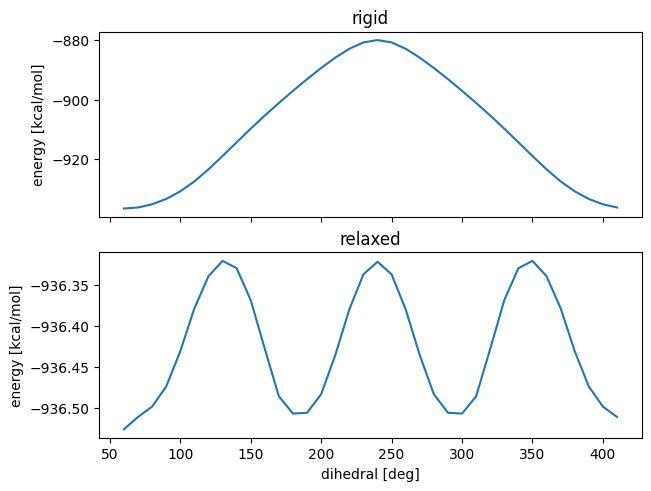

In [154]:

from matplotlib import pyplot as plt

factor = units.eV / (units.kcal / units.mol)
with plt.style.context('default'):

    fig, axes = plt.subplot_mosaic(
        """
        a
        b
        """,
        sharex=True,
        constrained_layout=True
    )
    i = 'a'
    axes[i].plot(dihedrals + 60, rigid_energies*factor)#, label='rigid')
    # axes[i].legend()
    axes[i].set(
        title='rigid',
        ylabel='energy [kcal/mol]'
    )
    i = 'b'
    axes[i].plot(dihedrals + 60, relaxed_energies*factor)#, label='relaxed')
    axes[i].set(
        title='relaxed',
        xlabel='dihedral [deg]', ylabel='energy [kcal/mol]'
    )
    # axes[i].legend()

    plt.savefig('ethane-pes-dihedral.png')
    plt.show()    